In [396]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import math
import matplotlib.image as mpimg 

In [397]:
def Gradient_Magnitude(img): 
    kernelx = np.array([[1,0,-1],[2,0,-2],[1,0,-1]]) #we use sobel filters in each direction 
    kernely = np.array([[1,2,1],[0,0,0],[-1,-2,-1]])
    imgx = cv2.filter2D(img,-1,kernelx) #we convolve the filters
    imgy = cv2.filter2D(img,-1,kernely)
    imgmag = img.copy()
    if isinstance(img[0][0],np.uint8): #grayscale image support
        for i in range(img.shape[0]):
            for j in range(img.shape[1]):
                imgmag[i][j] = math.sqrt(imgx[i][j]**2 + imgy[i][j]**2)
    else:
        for i in range(img.shape[0]): #colorimage
            for j in range(img.shape[1]):
                imgmag[i][j][0] = math.sqrt(imgx[i][j][0]**2 + imgy[i][j][0]**2)
                imgmag[i][j][1] = math.sqrt(imgx[i][j][1]**2 + imgy[i][j][1]**2)
                imgmag[i][j][2] = math.sqrt(imgx[i][j][2]**2 + imgy[i][j][2]**2)
    return imgmag

def Laplacian_(img): 
    kernell = np.array([[0,1,0],[1,-4,1],[0,1,0]]) #this is the laplacian filter
    imgl = cv2.filter2D(img,ddepth=cv2.CV_32F, kernel = kernell) #we convolve in float mode to have negative values and account for change
    return imgl

def zerocrossings(imgl,img):
    signimg = np.sign(imgl) #we get sign of laplacian
    xtruthval = signimg[:-1, :-1] - signimg[:-1, 1:] < 0 #we substract horizontally and set truth value accordingly
    ytruthval = signimg[:-1, :-1] - signimg[1:, :-1] < 0 #we substract vertically 
    crossings =  np.logical_or(xtruthval, ytruthval).astype(float) #if there is a True change in value we set 1
    if isinstance(img[0][0],np.uint8):
        imgform = img.copy()
        for i in range(imgform.shape[0]-1):
            for j in range(imgform.shape[1]-1):
                imgform[i][j] = crossings[i][j]
        for i in range(imgform.shape[0]):
            imgform[i][imgform.shape[1]-1] = 0
        for i in range(imgform.shape[1]):
            imgform[imgform.shape[0]-1][i] = 0
    else:
        imgform = imgl.copy()
        for i in range(imgform.shape[0]-1):
            for j in range(imgform.shape[1]-1):
                imgform[i][j][0] = crossings[i][j][0] #we pad
                imgform[i][j][1] = crossings[i][j][1]
                imgform[i][j][2] = crossings[i][j][2]
        for i in range(imgform.shape[0]):
            imgform[i][imgform.shape[1]-1][0] = 0
            imgform[i][imgform.shape[1]-1][1] = 0
            imgform[i][imgform.shape[1]-1][2] = 0
        for i in range(imgform.shape[1]):
            imgform[imgform.shape[0]-1][i][0] = 0
            imgform[imgform.shape[0]-1][i][1] = 0
            imgform[imgform.shape[0]-1][i][2] = 0
    return imgform



def Laplacian_Edge_Detection(img,threshold): #we input image and threshold value from 0 to 255
    if isinstance(img[0][0],np.uint8):
        imgm = Gradient_Magnitude(img) #we evaluate gradient magnitude
        imgt = img.copy()
        for i in range(1,imgm.shape[0]-1):
            for j in range(1,imgm.shape[1]-1):
                flag = 0
                for m in range(-1,2):
                    for n in range(-1,2):
                        a = imgm[i+m][j+n]
                        if a > threshold: #we apply thresholding and hysteresis
                            flag = 1 #if a pixel is above the threshold we break and move on
                            break
                    if flag == 1:
                        break
                if flag == 0:
                    imgt[i][j] = 0
                else:
                    imgt[i][j] = 255
    else:
        kernelG = np.array([[0,0,-1,0,0],[0,-1,-2,-1,0],[-1,-2,16,-2,-1],[0,-1,-2,-1,0],[0,0,-1,0,0]])
        imgG = cv2.filter2D(img,ddepth=cv2.CV_32F,kernel = kernelG)
        imgm = Gradient_Magnitude(imgG) #we evaluate gradient magnitude
        imgt = imgG.copy()
        for i in range(1,imgm.shape[0]-1):
            for j in range(1,imgm.shape[1]-1):
                flag = 0
                for m in range(-1,2):
                    for n in range(-1,2):
                        for k in range(len(imgm[i][j])):
                            a = imgt[i+m][j+n][k]
                            if a > threshold: #we apply thresholding and hysteresis
                                flag = 1 
                                break
                        if flag == 1:
                            break
                    if flag == 1:
                        break
                if flag == 0:
                    imgt[i][j][0] = 0
                    imgt[i][j][1] = 0
                    imgt[i][j][2] = 0
                else:
                    imgt[i][j][0] = 1 #this for bitwise operation
                    imgt[i][j][1] = 1
                    imgt[i][j][2] = 1
    imgl = Laplacian_(imgt) #we apply laplacian filter on non-thresholded image
    zc = zerocrossings(imgl,img) #we get contours image
    imgand = cv2.bitwise_and(imgt,zc) #AND function
    return imgand

def propercolor(img1):
    b,g,r = cv2.split(img1) #this converts image properly when read through cv2
    rgb_img1 = cv2.merge([r,g,b]) 
    return rgb_img1

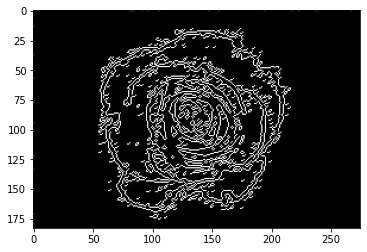

In [398]:
pic = cv2.imread('rose.jpeg')
ed = Laplacian_Edge_Detection(pic,100)
plt.imshow(ed)

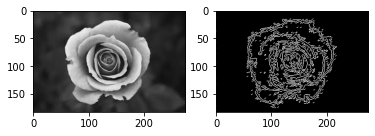

In [399]:
plt.subplot(1,2,1)
plt.imshow(pic)
plt.subplot(1,2,2)
plt.imshow(ed)

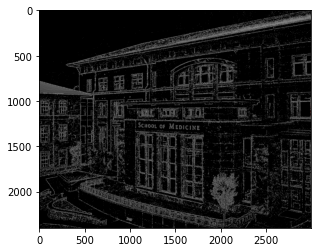

In [400]:
openc = cv2.imread('emory.jpg')
pic1 = propercolor(openc)
ed1 = Laplacian_Edge_Detection(pic1,150)
plt.imshow(ed1)

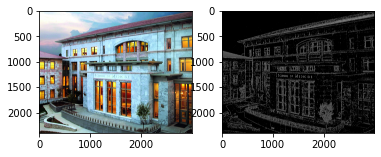

In [401]:
plt.subplot(1,2,1)
plt.imshow(pic1)
plt.subplot(1,2,2)
plt.imshow(ed1)

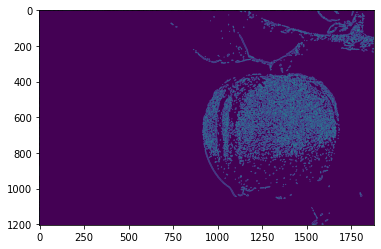

In [402]:
pic3 = mpimg.imread('gray.jpeg')
ed3 = Laplacian_Edge_Detection(pic3,100)
plt.imshow(ed3)

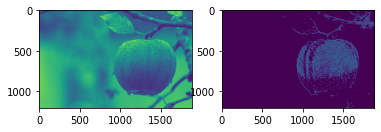

In [403]:
plt.subplot(1,2,1)
plt.imshow(pic3)
plt.subplot(1,2,2)
plt.imshow(ed3)

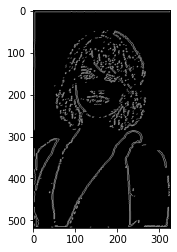

In [404]:
pic4 = cv2.imread('emma.png')
ed4 = Laplacian_Edge_Detection(pic4,90)
plt.imshow(ed4)

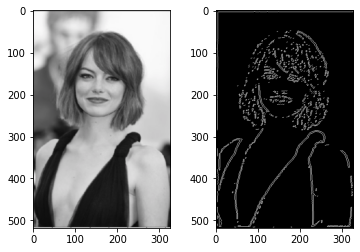

In [405]:
plt.subplot(1,2,1)
plt.imshow(pic4)
plt.subplot(1,2,2)
plt.imshow(ed4)